In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm
import seaborn as sns
from matplotlib.gridspec import GridSpec as gs

#### Load gff info

In [3]:
def read_gff(gff_file, retrieve_keys = ['Locus','Name']):
    import pandas as pd
    columns=['Seqid','Source','type','Start',
             'End','Score','Strand','Phase'] + retrieve_keys
    df_raw = []
    with open(gff_file, 'r') as f:
        while True:
            line = f.readline().rstrip()
            if line == '':
                f.close()
                break
            else:
                line = line.split('\t')
                info = line[:-1]
                info_dict={}
                for x in line[-1].split(';'):
                    if x.count('=') == 1:
                        k,v = x.split('=')
                        info_dict[k] = v
                info += [info_dict[k] for k in retrieve_keys]
                df_raw.append(info)
    df = pd.DataFrame(df_raw,columns=columns)
    df[['Start','End']] = df[['Start','End']].astype(int)
    return df.sort_values(by='Start').reset_index(drop=True)

In [5]:
gff = read_gff('Mycobacterium_tuberculosis_H37Rv_gff_v3.gff')
idap_intensity = pd.read_excel('5_samples_whiB2.xlsx')
tss = pd.read_excel('pgen.1005641.s010.xlsx',sheet_name='All TSSs')
mut_profile = pd.read_csv('whiB2-fbiA_event.csv')

In [6]:
mut_profile.head()

,eve,loc
0,1,3640152
1,2,3640164
2,1,3640167
3,1,3640171
4,1,3640175


In [13]:
# Specify region
start,end = idap_intensity['Position'].min(),idap_intensity['Position'].max()

# Load all TSSs in the neighborhood
inrange_tss = tss[(tss['Coordinate (genome version NC_000962)']<end)&\
     (tss['Coordinate (genome version NC_000962)']>start)]

# Interpolate data
interpolated = np.interp(np.linspace(mut_profile['loc'].min(),mut_profile['loc'].max(),200),
                         xp=mut_profile['loc'],fp=mut_profile['eve'])

/Users/jz-rolling/Desktop/OMEGA_GUI/venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


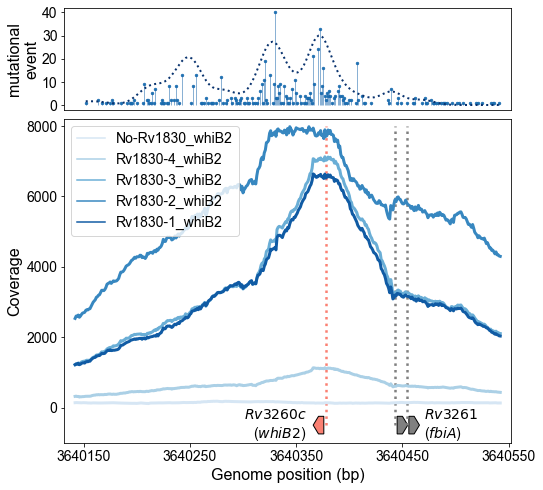

In [14]:
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler
fig=plt.figure(figsize=(8,8))
grids = gs(8,1)

ax1=fig.add_subplot(grids[:2,:])
ax2=fig.add_subplot(grids[2:,:])
sns.lineplot(data=idap_intensity,x='Position',y='Cov',hue='id',lw=3,palette='Blues',
             hue_order=['No-Rv1830_whiB2',
                        'Rv1830-4_whiB2',
                        'Rv1830-3_whiB2',
                        'Rv1830-2_whiB2',
                        'Rv1830-1_whiB2'],ax=ax2)
ax2.set_ylim(-1000,8200)
ax2.set_xlim(start-10,end+10)
ax2.text(3640360,-500,'${Rv3260c}$\n(${whiB2}$)',fontsize=14,ha='right',va='center',fontname='Arial')
ax2.text(3640470,-500,'${Rv3261}$\n(${fbiA}$)',fontsize=14,ha='left',va='center',fontname='Arial')
for i,(s,c,cov) in enumerate(inrange_tss[inrange_tss.columns[1:4]].values):
    if s=='+':
        color='grey'
        dx=10
    else:
        color='salmon'
        dx=-10
    ax2.arrow(c,-500,dx,0,
             fc=color,ec='black',lw=1,  
             width=500,head_width=500,
             head_length=min(5,abs(dx)),length_includes_head=True)
    ax2.vlines(x=c-0.2*dx,ymin=-500,ymax=8000,ls=':',color=color,lw=2.5)
ax2.set_xticks([3640150,3640250,3640350,3640450,3640550])
ax2.set_xticklabels([int(x) for x in ax2.get_xticks()],fontsize=14,fontname='Arial')
ax2.set_xlabel('Genome position (bp)',fontsize=16,fontname='Arial')
ax2.set_ylabel('Coverage',fontsize=16,fontname='Arial')
ax2.set_yticks([0,2000,4000,6000,8000])
ax2.set_yticklabels([int(x) for x in ax2.get_yticks()],fontsize=14,fontname='Arial')
ax2.legend(prop={'family':'Arial','size':14},loc=2)
ax1.set_xlim(start-10,end+10)
ax1.vlines(x=mut_profile['loc'],ymin=np.zeros(len(mut_profile)),ymax=mut_profile['eve'],
           color=cm.get_cmap('Blues')(0.8),lw=0.5)
ax1.scatter(x=mut_profile['loc'],y=mut_profile['eve'],fc=None,
            ec=cm.get_cmap('Blues')(0.8),s=8,lw=0.5)
ax1.set_xticks([])
ax1.set_yticklabels([int(x) for x in ax1.get_yticks()],fontsize=14,fontname='Arial');
ax1.text(-0.092,0.5,'mutational\nevent',fontsize=16,fontname='Arial',transform=ax1.transAxes,rotation=90,ha='center',va='center')
ax1.plot(np.linspace(mut_profile['loc'].min(),mut_profile['loc'].max(),200),
         MinMaxScaler().fit_transform(gaussian_filter1d(interpolated,sigma=5).reshape(-1,1)).flatten()*30,
         color=cm.get_cmap('Blues')(0.99),ls=':',lw=2)
plt.savefig('IDAP-TSS.png',
           bbox_inches='tight',dpi=160)